<a href="https://colab.research.google.com/github/luckyme410/summary_champ/blob/main/summarize_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## В приведенном ноутбуке мы генерим саммари спортивные статьи с Чемпионат.com (https://www.championat.com/). Статьи выбраны по 7 видам спорта (футбол, баскетбол, хоккей, ...). Для саммаризации текстов использовались: mT5-small и mBart-ru

In [ ]:
! pip install datasets transformers rouge-score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=8b9426565eceadad99182f9b025bc8ed974d5350810b3e3681a7d771e1df524f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

In [ ]:
!pip install -U nltk

In [ ]:
import evaluate
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Загрузим данные:

In [ ]:
!unzip /content/articles_championat2.zip

Archive:  /content/articles_championat2.zip
  inflating: articles_championat2.csv  


In [ ]:
# Данные парсились с сайта Чемпионат.com
data = pd.read_csv("/content/articles_championat2.csv") # /content/drive/MyDrive/articles_championat.csv
print('Кол-во статей:', data.shape[0])
print()
data.head()

Кол-во статей: 26311



,title,subtitle,text,date,sport
0,"Какая команда станет чемпионом, когда коронуют...","Концовка сезона интереснее, чем кажется.",Последний перед паузой в календаре Ф-1 Гран-пр...,2024-11-20,auto
1,"Бибер испортил Ferrari, Том Круз «опозорил» Bu...",Даже если вы мировая знаменитость с кучей дене...,Производители люксовых автомобилей тщательно с...,2024-11-18,auto
2,Из Формулы-1 уходят 5 пилотов. Что их ждёт в б...,"Некоторые могут остаться в Ф-1, но в другом ка...",В конце сезона-2024 чемпионат Формулы-1 покину...,2024-11-16,auto
3,Швейцарцы спасли гоночную карьеру чемпиона мир...,Чехи теперь совсем не против видеть Кирилла Ку...,Буквально в апреле 2024 года карьера российско...,2024-11-14,auto
4,Одного из главных людей в Ф-1 уволили перед ра...,Организаторам чемпионата придётся объясниться.,"Во вторник, 12 ноября, Формула-1 сделала громк...",2024-11-13,auto


In [ ]:
# описание столбцов:

# text - статья
# title - ее заголовок
# subtitle - подзаголовок статьи
# date - дата публикации (str)
# sport - вид спорта

Нас интересуют 3 столбца: text (статья), title и subtitle. Title + subtitle и будут кратким содержанием статьи (gold standard).
Конечно заголовок и подзаголовок статьи тянут на саммари лишь с натяжкой, но тем не менее.

In [ ]:
# соединим title & subtitle:
data['title'] = data['title'].apply(lambda txt: txt + ' ' if txt[-1] in '.?!;' else txt + '. ')                               # ?????
data['summary'] = data['title'] + data['subtitle']

In [ ]:
# вот что получилось:
data['summary'].values[:10].tolist()

['Какая команда станет чемпионом, когда коронуют Макса и ещё 5 интриг финала сезона Ф-1. Концовка сезона интереснее, чем кажется.',
 'Бибер испортил Ferrari, Том Круз «опозорил» Bugatti. Как звёзды попадают в чёрные списки. Даже если вы мировая знаменитость с кучей денег, не факт, что вам продадут желаемую машину.',
 'Из Формулы-1 уходят 5 пилотов. Что их ждёт в будущем и есть ли шансы на возвращение? Некоторые могут остаться в Ф-1, но в другом качестве.',
 'Швейцарцы спасли гоночную карьеру чемпиона мира из России. Он ответил серией побед. Чехи теперь совсем не против видеть Кирилла Куцкова у себя в гостях. А вот сербские власти ведут себя ну очень странно.',
 'Одного из главных людей в Ф-1 уволили перед развязкой сезона. Ещё и публично соврали. Организаторам чемпионата придётся объясниться.',
 '«У каждого есть срок годности». «Мерседес» сам избавился от Хэмилтона? Тото Вольф рад, что ему не пришлось говорить Хэмилтону, что его срок вышел.',
 '4 редких случая, когда сын-гонщик превзош

### Анализ текстов:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
%%time
# кол-во слов (токенов) в статьях:
data['text_num_tok'] = data['text'].apply(lambda txt: len(nltk.word_tokenize(txt)))

# кол-во слов (токенов) в саммари:
data['summary_num_tok'] = data['summary'].apply(lambda txt: len(nltk.word_tokenize(txt)))

CPU times: user 3min 50s, sys: 543 ms, total: 3min 50s
Wall time: 3min 55s


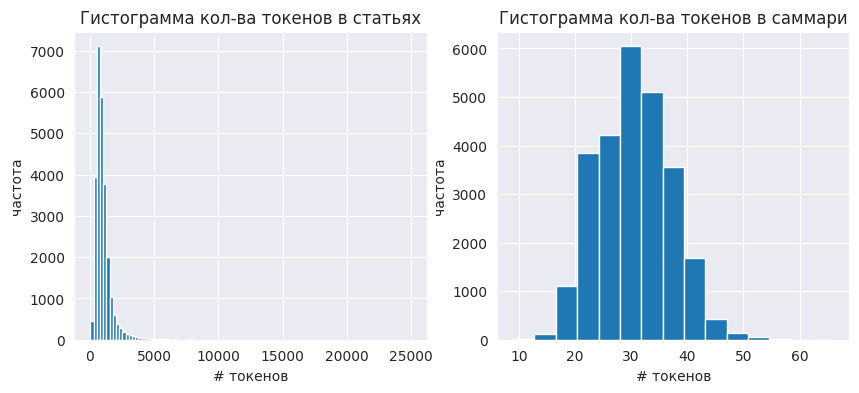

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('Гистограмма кол-ва токенов в статьях')
plt.hist(data['text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота')

plt.subplot(122)
plt.title('Гистограмма кол-ва токенов в саммари')
plt.hist(data['summary_num_tok'], bins=15)
plt.xlabel('# токенов')
plt.ylabel('частота');

Ого, похоже у них работают фанаты Льва Николаевича... Исключим лонгриды

квантиль 0.995: 4655


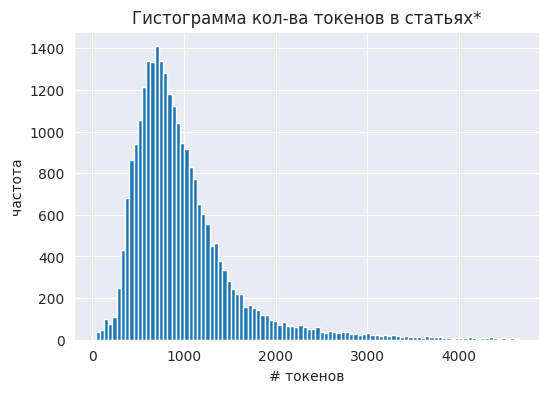

In [ ]:
# квантиль 0.995:
q995 = round(data['text_num_tok'].quantile(0.995))
print('квантиль 0.995:', q995)

# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(6, 4))
plt.title('Гистограмма кол-ва токенов в статьях*')
plt.hist(data.loc[mask, 'text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота');

Длинные статьи будут обрезаться при токенизации, поэтому не переживаем за них. Посмотрим на самые короткие:

In [ ]:
# квантиль 1%:
q01 = round(data['text_num_tok'].quantile(0.01))
print('квантиль 0.01:', q01)
print()

mask = data['text_num_tok'] <= q01
short_texts = data.loc[mask, ['text']].values.tolist()

# выберем 15 рандомных 'коротышей':
random_idx = np.random.choice(np.arange(len(short_texts)), size=15 ,replace=False)
for i in random_idx:
  print(short_texts[i][0])
  print()

квантиль 0.01: 224

12 октября в Эр-Рияде (Саудовская Аравия) пройдёт большой вечер профессионального бокса, главным событием которого станет долгожданный поединок за звание абсолютного чемпиона мира в полутяжёлом весе между непобеждёнными россиянами Артуром Бетербиевым и Дмитрием Биволом.
Бетербиев все 20 профессиональных поединков завершил досрочными победами, он владеет поясами чемпиона WBC, WBO и IBF. Бивол также непобеждённый боксёр и выиграл 23 боя, в его активе титулы WBA Super и IBO.
Помимо противостояния россиян за звание абсолютного чемпиона мира, на турнире запланировано ещё несколько ярких поединков. В частности, Джей Опетайя будет защищать пояс IBF в тяжёлом весе в бою с Джеком Мейсси.
Накануне прошла пресс-конференция в преддверии турнира. А сегодня состоялась церемония взвешивания и финальные битвы взглядов.
«Чемпионат» провёл онлайн-трансляцию взвешивания и событий вокруг него.
Вы можете настроить удобный параметр автообновления, изменив его с помощью кнопки под стрелко

Короткие статьи выглядят нормально. Теперь посмотрим на корреляцию между длиной статьи и саммари:

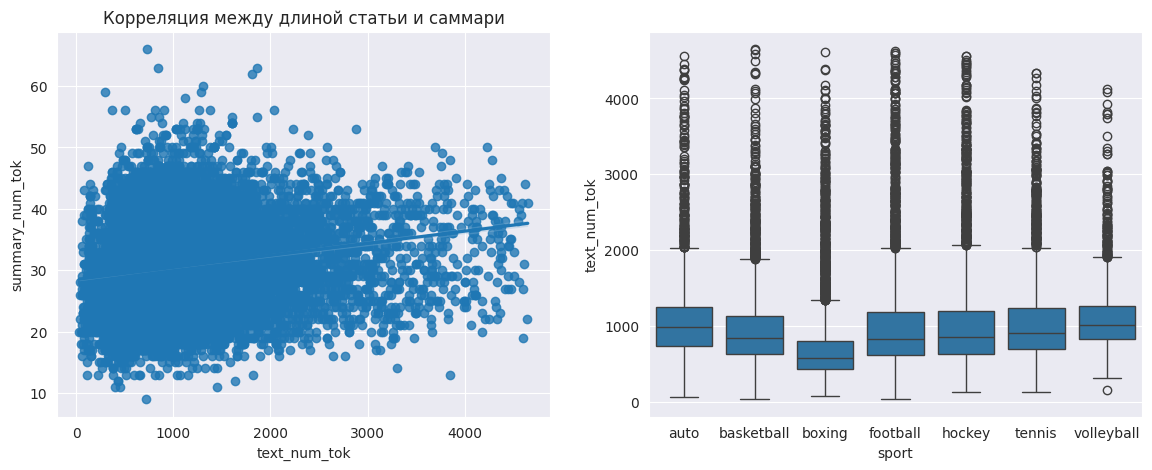

In [ ]:
# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
sns.regplot(data=data[mask],
            x='text_num_tok',
            y='summary_num_tok',
            ax=ax1)
plt.title('Корреляция между длиной статьи и саммари')

# длина статьи в разрезе по видам спорта:
ax2 = plt.subplot(122)
sns.boxplot(data=data[mask],
            x='sport',
            y='text_num_tok',
            ax=ax2);

Корреляция присутствует, но не очень сильная. По каждому виду спорта встречаются весьма длинные тексты. В целом про бокс статьи существенно короче.

Теперь соберем все символы встречающиеся в текстах:

In [ ]:
all_chars = set()  # все символы

for txt in data['text'].values:
  chars = set(txt)
  all_chars.update(chars)

for txt in data['summary'].values:
  chars = set(txt)
  all_chars.update(chars)

In [ ]:
print('всего символов:', len(all_chars))

всего символов: 675


In [ ]:
# красота, давайте посмотрим на них:
all_chars

{'\n',
 '\r',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '~',
 '\xa0',
 '¡',
 '£',
 '©',
 '«',
 '¬',
 '\xad',
 '¯',
 '°',
 '²',
 '·',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 'É',
 'Ë',
 '×',
 'Ü',
 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ë',
 'í',
 'ñ',
 'ó',
 'ô',
 'õ',
 'ö',
 '÷',
 'ú',
 'ü',
 'ė',
 'ĸ',
 'Ł',
 'ł',
 'Š',
 'ū',
 'ų',
 'ž',
 '́',
 '̆',
 '̶',
 'ε',
 'ι',
 'κ',
 'ο',
 'ρ',
 'ς',
 'Ё',
 'Ѕ',
 'Ї',
 'Ј',
 'Џ',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 

Ого, сколько смайликов. Увидим как LLM'ки вывезут все это дело.

### Datasets:

In [ ]:
import datasets

In [ ]:
# данные будут в формате Dataset:
dataset = datasets.Dataset.from_pandas(data.loc[:, ['text', 'summary']])
dataset = dataset.shuffle(seed=9)

In [ ]:
# разделим на train/eval части:
dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=11)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 24995
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1316
    })
})

### Качество baseline'a
В роли baseline предсказаний выберем первые 3 предложения из статьи (prediction) и сравним с саммари (gold standard)

In [ ]:
def get_baseline_preds(examples):
  # первые 3 предложения + разделитель '\n' между ними (метрики требуют)
  base_preds = ['\n'.join(nltk.sent_tokenize(doc)[:3]) for doc in examples['text']]
  # разделитель '\n' между предложениями в саммари (метрики требуют)
  base_true = ['\n'.join(nltk.sent_tokenize(doc)) for doc in examples['summary']]

  return {'base_preds': base_preds, 'base_true': base_true}

base_results =  dataset['test'].map(get_baseline_preds, batched=True)

Map:   0%|          | 0/1842 [00:00<?, ? examples/s]

In [ ]:
# вот что получилось:
base_results['base_preds'][:4]

['Мы все знали, что Кирилл Капризов — отличный хоккеист.\nНастоящая звезда.\nИ, вероятно, лучший игрок в истории «Миннесоты».',
 'Жизнь на рынке в НБА даже после закрытия окна переходов продолжает бить ключом.\nДа, переходы между командами в нынешнем сезоне уже невозможны, но зато остались ещё лакомые кусочки в лицах тех баскетболистов, контракты которых были выкуплены.\nБольшое внимание было привлечено к двум персонажам — Андре Драммонду и Ламаркусу Олдриджу.',
 'Карантин из-за эпидемии коронавируса выбил множество людей из их привычного ритма жизни.\nНо далеко не все готовы расстаться со своими привычками — причём пример знаменитого испанского мотогонщика Тони Боу показывает, что ради любимых занятий далеко не всегда нужно нарушать режим самоизоляции.\nБоу «карантинит» в городке Ла-Масана в Андорре.',
 'Неожиданный субботний прорыв «Мерседеса» обеспечил максимальную интригу перед стартом Гран-при Мексики Формулы-1: кто из лидеров окажется быстрее в гоночном режиме, без шин «софт», и 

In [ ]:
# метрики качества: rouge и meteor
# качество для baseline:
result = rouge_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true'], use_stemmer=True)
result.update(meteor_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true']))

{k: round(100*v, 4) for k, v in result.items()}

{'rouge1': 12.1767,
 'rouge2': 2.1169,
 'rougeL': 12.0133,
 'rougeLsum': 12.0952,
 'meteor': 17.544}

Будем сравнивать результаты mT5/ruBart с этими показателями

### Выбор модели:

In [ ]:
# models:
model_checkpoint = "google/mt5-small"
#model_checkpoint = "IlyaGusev/mbart_ru_sum_gazeta"

### Токенизация данных:

In [ ]:
from transformers import AutoTokenizer

# грузим токенизатор под выбранную модель:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# is fast:
tokenizer.is_fast

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


True

Сколько символов из all_chars будут непонятны для выбранного токенизатора:

In [ ]:
unk_chars = [char for char in all_chars if '<unk>' in tokenizer.convert_ids_to_tokens(tokenizer(char)["input_ids"])]
print('неизвестных символов:', len(unk_chars))
unk_chars[:10]

неизвестных символов: 56


['🧨', '🕢', '🚓', '🕡', '🛬', '🕗', '🫂', '🚅', '⏲', '🧤']

In [ ]:
#  для mT5 надо указать префикс, чтобы модель понимала какую задачу ей надо решать
if model_checkpoint in ["google/mt5-small", "google/mt5-base"]:
    prefix = "summarize: "  # 'суммировать: '  "summarize: "
else:
    prefix = ""

prefix

'summarize: '

In [ ]:
# токенизируем статьи и саммари:

# максимальное число токенов для статьи/саммари
max_input_length = 768 # 512 768 1024
max_target_length = 128

def preprocess_function(examples):
    # добавим prefix
    examples['text'] = [prefix + doc for doc in examples["text"]]
    # input_ids + attention_mask:
    model_inputs = tokenizer(examples['text'], max_length=max_input_length, truncation=True)

    # labels:
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# обработаем данные батчами:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/24995 [00:00<?, ? examples/s]

Map:   0%|          | 0/1316 [00:00<?, ? examples/s]

In [ ]:
# prefix + text:
for i in range(3):
  print(tokenized_datasets['train']['text'][i][:128])

summarize: 10-й тур РПЛ уже остался в прошлом. Самое время определить лучшего футболиста, а кандидатов хватает.
Участвуйте в гол
summarize: Международная автомобильная федерация ФИА начала расследование возможной утечки конфиденциальной информации — и его ф
summarize: Главный матч седьмого тура женской волейбольной Суперлиги проходил в Краснодаре. Лидер чемпионата – местное «Динамо» 


In [ ]:
# удалим текстовые данные + __index_level_0__
drop_columns = ['text', 'summary']
if '__index_level_0__' in tokenized_datasets['test'].features.keys():
  drop_columns.append('__index_level_0__')

tokenized_datasets = tokenized_datasets.remove_columns(drop_columns)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 24469
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1842
    })
})

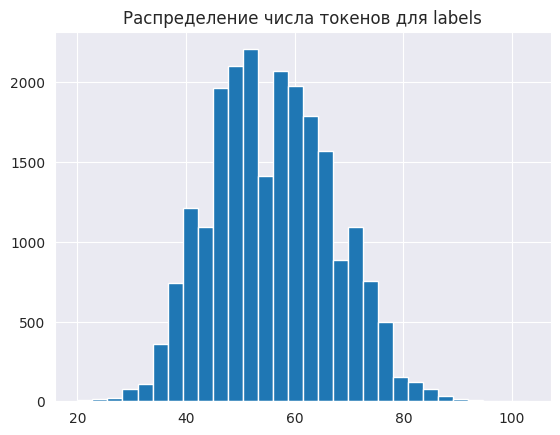

In [ ]:
# заценим распределение числа токенов в labels
# прикинем сколько токенов надо генерить для предсказаний (max_new_tokens и min_new_tokens):
labels_num_tok = list(map(len, tokenized_datasets['train']['labels']))

plt.hist(labels_num_tok, bins=30)
plt.title('Распределение числа токенов для labels');

35-80 токенов должно хватить, т.е. max_new_tokens=80, min_new_tokens=35

### Импорт модели + data_collator

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, MT5ForConditionalGeneration #, Seq2SeqTrainingArguments, Seq2SeqTrainer

# импорт модели:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
#model = MT5ForConditionalGeneration.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Т.к. данные подаются в модель параллельно, они должны быть одной длины.
Добить input_ids/labels pad_token'ми до одной длины нам поможет data_collator, кроме того, он заменит pad_token'ы на -100 в labels чтобы loss их игнорил.

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### Dataloaders:

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE=8

In [ ]:
train_loader = DataLoader(tokenized_datasets['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)


test_loader = DataLoader(tokenized_datasets['test'],
                          batch_size=3*BATCH_SIZE,
                          shuffle=False,
                          collate_fn=data_collator)

In [ ]:
# работает ли?
for x_batch in test_loader:
  break
{k: v.shape for k,v in x_batch.items()}

{'input_ids': torch.Size([24, 1024]),
 'attention_mask': torch.Size([24, 1024]),
 'labels': torch.Size([24, 70]),
 'decoder_input_ids': torch.Size([24, 70])}

In [ ]:
# -100 в labels:
x_batch['labels'][:2]

tensor([[   404,   6170,  12059, 117420,   3053,  44616,    324,   1836,   6439,
         106816,    685,  31605,    587,   2385,   2536,  18600,   2536,    259,
          72808,    354,    315,  12295,    279,    259, 106314,   6125,    291,
            259,  93745,    920,    259,   4466,  55293, 175745,  34915,    388,
            259,  14259,   1104, 100113,   1625, 143757,  33982,    259,    279,
         172620,  28190,   4614,    259,  55173,   1011,  30425,  17951,    637,
            260,      1,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100],
        [   404,   2080,   7912,    259,    735,  23885,    433,   4306,   3248,
            264,  83555,    507,  14719, 147203,    637,   1836,    867,    404,
         186655,    946,    436,   5420,   6277,   1592,    315,  38606,   4262,
          24533,  59779,    902,    310,   1285,    605,  40066,   3888,    260,
           1454, 238634,  15826,  12719, 232215,  17850,  6

### Метрики качества:
Оценивать качество сгенерированного текста будем по двум метрикам: rouge и meteor.

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Replace -100 in the predictions as we can't decode them.
    #predictions = [np.where(l != -100, l, tokenizer.pad_token_id) for l in predictions]
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = [np.where(l != -100, l, tokenizer.pad_token_id) for l in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Add mean generated length
    #prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    #result["gen_len"] = np.mean(prediction_lens)

    result.update(meteor_metric.compute(predictions=decoded_preds, references=decoded_labels))
    return {k: round(100*v, 4) for k, v in result.items()}

### Model to GPU/CPU:

In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
# device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

### Оценим кач-во модели без fine-tuning'а

In [ ]:
# eval:
datasets = {'test': test_loader}
#_ = 0

model.eval()
for name, dataset in datasets.items():
  eval_pred = []
  eval_true = []
  for x_batch in tqdm(dataset):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                             max_new_tokens=80,
                             min_new_tokens=35,
                             no_repeat_ngram_size=2,
                             num_beams=7,
                             early_stopping=True
      )

    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break

  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))
  print(model_checkpoint)
  print(scores)

100%|██████████| 165/165 [13:55<00:00,  5.07s/it]


google/mt5-small
{'rouge1': 3.3631, 'rouge2': 0.5423, 'rougeL': 3.3597, 'rougeLsum': 3.3765, 'meteor': 9.0854}


In [ ]:
#                                    google/mt5-small:
# {'rouge1': 2.3104, 'rouge2': 0.3825, 'rougeL': 2.2953, 'rougeLsum': 2.2987, 'meteor': 7.2858}


In [ ]:
# примеры генерации текста на последнем батче:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
text_gen

['<extra_id_0> на ЧМ-2022 звучали из всех европейских стран – Швейцарии, Латвии, Финляндии и т.д..',
 '<extra_id_0> сказал: «Я не обращался, потому что он получил травму». Квинси Промес и обвинил его в покушении',
 '<extra_id_0> о российском теннисе и также обозначено три важнейшие темы: выступление спортсменов на личных турнирах.',
 '<extra_id_0> и т.д. будет очень интересно показать себя перед скаутами клубов из топ-чемпионатов мира по футболу.',
 '<extra_id_0> очень событийный аргентинец оказался в финале чемпионата Европы в Неаполе и сыграли в первом же туре.',
 '<extra_id_0> на первых минутах матча с словенцами. Словакия проиграла Англии 0:1. В этом случае не было никаких изменений.',
 '<extra_id_0> оказался провалом Петра Яна в бою с Мерабом Двалишвили. Это было бы очень интересно. В итоге... <extra_id_10>',
 '<extra_id_0> Медведев описал свои ощущения от нахождения на турнире категории ATP-500 в Дубае . <extra_id_10>.com.ua/',
 '<extra_id_0> не будет. Это всё! 😂 - именно так ока

Результаты ниже плинтуса, попробуем их улучшить.

### Fine-tuning модели:
Используем обучающую выборку для настройки моделей на генерацию заголовков в стиле Чемпионат.com

In [ ]:
# optimizer:
optim = AdamW(params=model.parameters(), lr=3e-4, weight_decay=0.01)

In [ ]:
# scheduler:
# линейно уменьшаем темп обучения (lr)
N_epochs = 1
n_train_steps = len(train_loader) * (N_epochs + 2)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=n_train_steps)

In [ ]:
# train/eval loops:
loss_hist = [] # train loss history
#eval_loss_hist = [] # train loss history
N_samples_eval = len(test_loader)
N_samples_train = len(train_loader)

for epoch in range(1, N_epochs+1):
  train_loss = 0
  model.train()
  for x_batch in tqdm(train_loader):
    # to device:
    x_batch = {k: v.to(device) for k,v in x_batch.items()}

    optim.zero_grad()
    output = model(**x_batch)
    output['loss'].backward()
    # clip grads:
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optim.step()

    # get and save loss:
    loss = output['loss'].detach().cpu().item()
    loss_hist.append(loss)
    train_loss += loss

    # scheduler step:
    lr_scheduler.step()

  #_ = 0

  # eval:
  eval_pred = []
  eval_true = []
  model.eval()
  for x_batch in tqdm(test_loader):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                              max_new_tokens=80,
                              no_repeat_ngram_size=2,
                              min_new_tokens=35,              #  no_repeat_ngram_size=2
                              num_beams=10,                    # или добавить рандомности: top_p=0.9, top_k=20, do_sample=True
                              early_stopping=True
      )
    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break
  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))

  print(f'\nepoch: {epoch}')
  print(f'train loss: {round(train_loss/N_samples_train, 5)}')
  print(scores)
  print()

100%|██████████| 55/55 [11:57<00:00, 13.04s/it]



epoch: 1
train loss: 4.09639
{'rouge1': 9.6377, 'rouge2': 1.639, 'rougeL': 9.4917, 'rougeLsum': 9.5841, 'meteor': 15.483}



качество саммаризации не очень, но прогресс, в сравнении с тем что было до fine-tuning'а очевиден.

In [ ]:
#                                          google/mt5-small:
# epoch: 1
#train loss: 4.3258
#{'rouge1': 10.4084, 'rouge2': 2.1722, 'rougeL': 10.3017, 'rougeLsum': 10.4099, 'meteor': 15.3521}


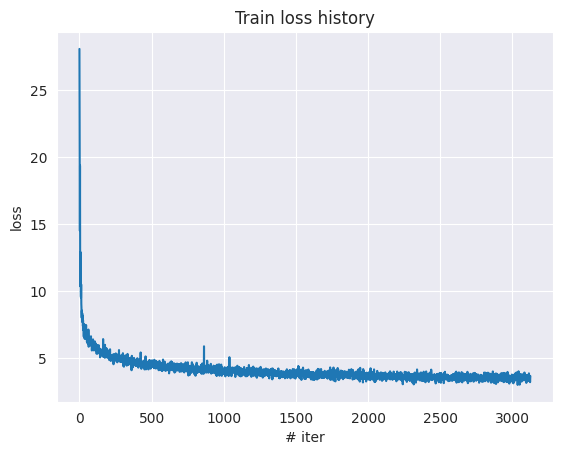

In [ ]:
plt.plot(loss_hist)
plt.title('Train loss history')
plt.xlabel('# iter')
plt.ylabel('loss');

Примеры генерации заголовков

In [ ]:
# примеры генерации заголовков из последнего батча:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
# google/mt5-small:
text_gen

['«Реал» выиграл в Лиге чемпионов. Навас впервые забил «Клермону» и вышел на рынок свободных агентов, а всё ещё ждёт возвращение в Париж.',
 'Уильямс на «Ролан Гаррос» — 2018 вышла из декрета. Мария Шарапова и Серена уехали из-за травмы руки.',
 '«Чемпионат» выиграл лучший нокаут в истории бокса. Поединок за титул Уртадо в полусреднем весе.',
 '«Ролан Гаррос» и «Лилль» в Пекине. Лучшие события 1 октября в Матч-центре «Чемпионата». Россиянка Кудерметова одержала второй титул в карьере.',
 'В матче «Динамо» и «Локомотив» в Баку. Что происходит в сезоне, а теперь ещё не будет.',
 '«Сент-Луис» выиграл Кубок Стэнли. Российский вратарь одержал первый трофей в истории НХЛ.',
 '«Ливерпуль» сыграет в финал Лиги чемпионов. Леброн Джеймс — лучший клуб мира. Что происходит в прошлом сезоне.',
 '«Астон Мартин» покинул «Феррари» в Формуле-1. Фернандо Алонсо и его родная команда уже не стали лучшими.',
 'Вадим Немков вернулся в тяжёлый вес, а ещё один из главных вопросов карьеры легендарного Фёдора Е

Качество модели получилось низким, это связано с тем, что решаемая задача больше относится к генерации заголовков, а не к саммари статей.
Заголовки с большой натяжкой можно отождествить саммари, тем не менее, в качестве упражнения - ок. Для улучшения предсказаний нужно собрать значительно больше данных.

In [ ]:
# Самое главное - увеличить объем данных.
# Добавить обрезанные части статей как новые с теми же заголовками (увеличим датасет ~ 2 раза) ?
# Кроме того, попробовать сделать больше эпох, обрезать градиенты, подобрать гиперпараметры оптимизатора и scheduler'a ...
# To be continued...